In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# SQLite3 버전 문제 해결: Chroma는 SQLite3 3.35.0 이상이 필요하지만 시스템에는 낮은 버전이 설치되어 있음
# pysqlite3-binary를 사용하여 더 높은 버전의 SQLite3을 제공
import sys
import pysqlite3

# 기존 sqlite3 모듈을 pysqlite3으로 대체
sys.modules['sqlite3'] = pysqlite3
print(f"Using SQLite version: {pysqlite3.sqlite_version}")

Using SQLite version: 3.46.1


In [3]:
from typing_extensions import TypedDict, List
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query : str
    context : list
    answer : str

graph_builder = StateGraph(AgentState)

In [4]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True
)

def web_search(state: AgentState) :
    query = state['query']
    results = tavily_search_tool.invoke(query)
    print(f"web search results == {results}")
    return {'context' : results}


/tmp/ipykernel_2193262/1354577508.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search_tool = TavilySearchResults(


In [5]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

generate_prompt = hub.pull('rlm/rag-prompt')
generate_llm = ChatOpenAI(model="gpt-4o")

def web_generate(state : AgentState) :
    context = state['context']
    query = state['query']
    rag_chain = generate_prompt | generate_llm | StrOutputParser()
    response = rag_chain.invoke({'question' : query, 'context' : context})
    return {'answer' : response}

In [6]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

basic_llm = ChatOpenAI(model="gpt-4o-mini")

def basic_generate(state : AgentState) :
    query = state['query']
    basic_llm_chain = basic_llm | StrOutputParser()
    response = basic_llm_chain.invoke(query)
    return {'answer' : response}

In [7]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal

class Route(BaseModel):
    target : Literal['vector_store', 'llm', 'web_search'] = Field(description="The target for the query to answer")


router_system_prompt = """
You are an expert at routing a user's question to 'vector_store', 'llm', or 'web_search'.
'vector_store' contains information about the AI trends.
if you think the question is simple enough use 'llm'
if you think you need to search the web to answer the question use 'web_search'
"""

router_prompt = ChatPromptTemplate.from_messages([
    ('system', router_system_prompt),
    ('user', '{query}')
])

router_llm = ChatOpenAI(model="gpt-4o-mini")
structured_router_llm = router_llm.with_structured_output(Route)


def router(state : AgentState):
    query = state['query']
    router_chain = router_prompt | structured_router_llm
    route = router_chain.invoke({'query' : query})
    print(f"router route == {route}")
    return route.target

In [8]:
graph_builder.nodes.clear()

graph_builder.add_node('web_search', web_search)
graph_builder.add_node('web_generate', web_generate)
graph_builder.add_node('basic_generate', basic_generate)

In [9]:
from self_rag_graph import graph as subgraph

graph_builder.add_node('sub_graph', subgraph)

Using SQLite version: 3.46.1
answer == {'answer': AIMessage(content='구글은 앤스로픽에 최대 20억 달러를 투자하기로 합의하고, 먼저 5억 달러를 투자했습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 2127, 'total_tokens': 2159, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 2048}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BsziLcjpsHpnFuBQOC2zjdYMxqRNa', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--0b25c119-6273-4cde-b888-854ba66905af-0', usage_metadata={'input_tokens': 2127, 'output_tokens': 32, 'total_tokens': 2159, 'input_token_details': {'audio': 0, 'cache_read': 2048}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}
context == [Document(id='8087dc56-3317-4651-a21f-3f58412e848e', metadata={'source': './doc

In [10]:
from langgraph.graph import START, END

graph_builder.add_conditional_edges(START, router,
                                    {
                                        'vector_store' : 'sub_graph',
                                        'llm' : 'basic_generate',
                                        'web_search' : 'web_search'
                                    })
graph_builder.add_edge('web_search', 'web_generate')
graph_builder.add_edge('web_generate', END)
graph_builder.add_edge('basic_generate', END)
graph_builder.add_edge('sub_graph', END)

In [11]:
graph = graph_builder.compile()

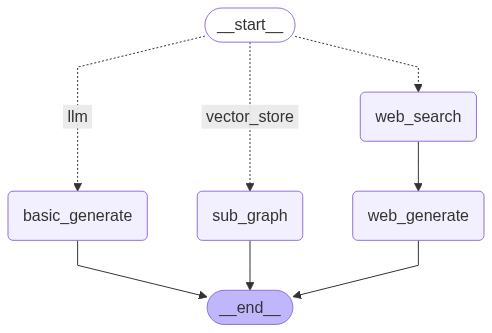

In [12]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
initial_state = {'query' : '시청역 근처 맛집 알려줘'}
graph.invoke(initial_state)

router route == target='web_search'
web search results == [{'title': '서울 시청역 맛집 추천 직접가본 15곳, 광화문 근처 맛집 - 네이버 블로그', 'url': 'https://m.blog.naver.com/kr_ou/223303323183', 'content': '동그리에요 :)\n\n\u200b\n\n지난번에 서울시청 스케이트 포스팅을 했으니\n\n이번엔 그 주변 맛집을 알려드리려고 해요!!\n\n\u200b\n\n제가 직접 먹어보고 평가한 맛집들이라\n\n주관적이지만 참고해서 방문하세요!!\n\n\u200b\n\n\u200b\n\n> 1. 반포식스 서울시청점\n> \n> \n> \n> 매일 11:00~21:30\n\n추울땐 따뜻한 국물이 생각나죠\n\n간단하게 먹을 수 있고 든든한 쌀국수집\n\n\u200b\n\n평일 점심에는 대기가 길어질 수 있으니\n\n피크 시간은 피해서 가보세요\n\n\u200b\n\n깔끔하고 맛도 괜찮아서 종종 갔던 반포식스입니다\n\n\u200b\n\nImage 5\n\n\u200b\n\n반포식스 쌀국수 11.0\n\n양치 차돌 쌀국수 10.5\n\n\u200b\n\n반포식스 서울시청점 서울특별시 중구 무교로 13 휘닉스빌딩 3층\n\n이 블로그의 체크인\n\n이 장소의 다른 글\n\n  \n\n> 2. 원당감자탕 서소문점\n\n따뜻한 탕이 있는 또 다른 곳\n\n이번엔 든든한 한식입니다\n\n\u200b\n\n뼈해장국이나 다른 뚝배기 요리들도 있어\n\n개인 취향에 맞게 골라먹을 수 있고 [...] 대방어는 인기가 좋아서 예약을 하고 가시는 게\n\n자리도 맡고 회도 선점하는 팁입니다\n\n\u200b\n\n은근 사람이 많이 오는 곳이라 못먹을 수도 있으니까요\n\n(가격은 매년 오르고 있네요ㅠ)\n\n\u200b\n\nImage 27\n\n\u200b\n\n대방어회 1인분 28.0\n\n광어우럭 소 35.0\n\n\u200b\n\n대찬횟집 서울특별시 종로구 우정국로2길

{'query': '시청역 근처 맛집 알려',
 'context': [{'title': '서울 시청역 맛집 추천 직접가본 15곳, 광화문 근처 맛집 - 네이버 블로그',
   'url': 'https://m.blog.naver.com/kr_ou/223303323183',
   'content': '동그리에요 :)\n\n\u200b\n\n지난번에 서울시청 스케이트 포스팅을 했으니\n\n이번엔 그 주변 맛집을 알려드리려고 해요!!\n\n\u200b\n\n제가 직접 먹어보고 평가한 맛집들이라\n\n주관적이지만 참고해서 방문하세요!!\n\n\u200b\n\n\u200b\n\n> 1. 반포식스 서울시청점\n> \n> \n> \n> 매일 11:00~21:30\n\n추울땐 따뜻한 국물이 생각나죠\n\n간단하게 먹을 수 있고 든든한 쌀국수집\n\n\u200b\n\n평일 점심에는 대기가 길어질 수 있으니\n\n피크 시간은 피해서 가보세요\n\n\u200b\n\n깔끔하고 맛도 괜찮아서 종종 갔던 반포식스입니다\n\n\u200b\n\nImage 5\n\n\u200b\n\n반포식스 쌀국수 11.0\n\n양치 차돌 쌀국수 10.5\n\n\u200b\n\n반포식스 서울시청점 서울특별시 중구 무교로 13 휘닉스빌딩 3층\n\n이 블로그의 체크인\n\n이 장소의 다른 글\n\n  \n\n> 2. 원당감자탕 서소문점\n\n따뜻한 탕이 있는 또 다른 곳\n\n이번엔 든든한 한식입니다\n\n\u200b\n\n뼈해장국이나 다른 뚝배기 요리들도 있어\n\n개인 취향에 맞게 골라먹을 수 있고 [...] 대방어는 인기가 좋아서 예약을 하고 가시는 게\n\n자리도 맡고 회도 선점하는 팁입니다\n\n\u200b\n\n은근 사람이 많이 오는 곳이라 못먹을 수도 있으니까요\n\n(가격은 매년 오르고 있네요ㅠ)\n\n\u200b\n\nImage 27\n\n\u200b\n\n대방어회 1인분 28.0\n\n광어우럭 소 35.0\n\n\u200b\n\n대찬횟집 서울특별시 종로구 우정국로2길 10 지하 1층\n\n이